In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [5]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [6]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [13]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Moving Average and Donchian Channel

In [221]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",  start_date),
            ("end_date",    end_date),
            ("ticker_list", ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("fast_mavg_log",                  fast_mavg_log),
            ("slow_mavg_log",                  slow_mavg_log),
            ("mavg_stepsize_log",              mavg_stepsize_log),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("vol_of_vol_window_1",          vol_of_vol_window_1),
            ("vol_of_vol_window_2",          vol_of_vol_window_2),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
            ("use_activation", use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                 long_only),
            ("use_coinbase_data",         use_coinbase_data),
            ("use_saved_files",           use_saved_files),
            ("saved_file_end_date",       saved_file_end_date),
            ("use_specific_start_date",   use_specific_start_date),
            ("signal_start_date",         signal_start_date),
            ("price_or_returns_calc",     price_or_returns_calc),
            ("notional_threshold_pct",    notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [223]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [225]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [227]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [229]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [231]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=50, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
    y_sum = y.rolling(r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
    y_sqr = (y**2).rolling(r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

    ## Calculate the R squared
    n = r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above 0.8 are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    return df

In [233]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [235]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [237]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                           use_activation=True, tanh_activation_constant_dict=None, 
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            use_activation=True, tanh_activation_constant_dict=None, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [239]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, ma_crossover_signal_weight,
                                                                donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                use_activation=True, tanh_activation_constant_dict=None, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                       exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                                   rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [241]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

## Moving Average Ribbon and Donchian Channel Breakout Parameter Optimization

In [244]:
start_date = pd.to_datetime('2021-06-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-06-30').date()
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 35
slow_mavg = 60
mavg_stepsize = 6
fast_mavg_log = 8
slow_mavg_log = 120
mavg_stepsize_log = 6
entry_rolling_donchian_window = 20
exit_rolling_donchian_window = 10
use_donchian_exit_gate = True
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-06-30'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.0
donchian_signal_weight = 1.0
use_activation = True
tanh_activation_constant_dict = None
lower_r_sqr_limit = 0.45
upper_r_sqr_limit = 0.8
r2_window = 50
vol_of_vol_window_1 = 20
vol_of_vol_window_2 = 15
vol_of_vol_z_score_window = 180
use_specific_start_date = True
signal_start_date = pd.Timestamp('2017-01-01').date()

In [246]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2021-06-01
end_date                      : 2023-12-31
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 35
slow_mavg                     : 60
mavg_stepsize                 : 6
fast_mavg_log                 : 8
slow_mavg_log                 : 120
mavg_stepsize_log             : 6
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.0

entry_rolling_donchian_window : 20
exit_rolling_donchian_window  : 10
use_donchian_exit_gate        : True
donchian_signal_weight        : 1.0

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
vol_of_vol_window_1           : 20
vol_of_vol_window_2           : 15
vol_of_vol_z_score_window     : 180

lower_r_sqr_limit         

## Analyze Walk Forward Analysis Results

In [43]:
df_performance_1 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-06-01-2023-11-30.pickle')
df_performance_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-12-01-2024-05-31.pickle')
df_performance_3 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2022-06-01-2024-11-30.pickle')
df_performance_4 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2022-12-01-2025-05-31.pickle')
df_performance = pd.concat([df_performance_1, df_performance_2, df_performance_3, df_performance_4], axis=0)

In [45]:
df_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-06-01-2025-05-31.pickle')

In [47]:
## Get In-Sample Weights
df_performance_1_is = df_performance_1[df_performance_1.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_2_is = df_performance_2[df_performance_2.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_3_is = df_performance_2[df_performance_3.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_4_is = df_performance_2[df_performance_4.sampling_category == 'in_sample'].reset_index(drop=True)

## Get Out of Sample Weights
df_performance_1_os = df_performance_1[df_performance_1.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_2_os = df_performance_2[df_performance_2.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_3_os = df_performance_3[df_performance_3.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_4_os = df_performance_4[df_performance_4.sampling_category == 'out_sample'].reset_index(drop=True)

In [49]:
print(df_performance_1_os.shape)
print(df_performance_2_os.shape)
print(df_performance_3_os.shape)
print(df_performance_4_os.shape)

(216, 37)
(216, 37)
(216, 37)
(216, 37)


In [51]:
df_performance_os = pd.concat([df_performance_1_os, df_performance_2_os, df_performance_3_os, df_performance_4_os], axis=0)
df_performance_is = pd.concat([df_performance_1_is, df_performance_2_is, df_performance_3_is, df_performance_4_is], axis=0)

In [53]:
df_performance_os_strategy_performance = df_performance_os.groupby(['mavg_strategy','donchian_strategy']).agg(
    sharpe_mean=('annualized_sharpe_ratio', 'mean'),
    sharpe_std=('annualized_sharpe_ratio', 'std'),
    max_dd_mean=('max_drawdown', 'mean'),
    hit_rate=('annualized_sharpe_ratio', 'mean'),
    n_slices=('annualized_sharpe_ratio', 'size'),
).reset_index()
df_performance_os_strategy_performance['strategy_score'] = (df_performance_os_strategy_performance['sharpe_mean'] -
                                                            0.5 * df_performance_os_strategy_performance['sharpe_std'] +
                                                            df_performance_os_strategy_performance['max_dd_mean'])

In [55]:
df_performance_is_strategy_performance = df_performance_is.groupby(['mavg_strategy','donchian_strategy']).agg(
    sharpe_mean=('annualized_sharpe_ratio', 'mean'),
    sharpe_std=('annualized_sharpe_ratio', 'std'),
    max_dd_mean=('max_drawdown', 'mean'),
    hit_rate=('annualized_sharpe_ratio', 'mean'),
    n_slices=('annualized_sharpe_ratio', 'size'),
).reset_index()

In [57]:
df_performance_os_strategy_performance.sort_values('strategy_score', ascending=False)

mavg_strategy donchian_strategy  sharpe_mean  sharpe_std  max_dd_mean  \
74    f16_s224_n8   en28_ex28_gTrue     0.616187    1.115842    -0.256440   
75    f16_s224_n8   en28_ex7_gFalse     0.616187    1.115842    -0.256440   
72    f16_s224_n8  en28_ex14_gFalse     0.616187    1.115842    -0.256440   
148   f18_s216_n4  en40_ex10_gFalse     0.555375    0.997791    -0.254732   
150   f18_s216_n4  en40_ex20_gFalse     0.555375    0.997791    -0.254732   
152   f18_s216_n4  en40_ex30_gFalse     0.555375    0.997791    -0.254732   
154   f18_s216_n4  en40_ex40_gFalse     0.555375    0.997791    -0.254732   
155   f18_s216_n4   en40_ex40_gTrue     0.555375    0.997791    -0.254732   
73    f16_s224_n8   en28_ex21_gTrue     0.613305    1.116763    -0.256440   
153   f18_s216_n4   en40_ex30_gTrue     0.521700    0.958558    -0.258644   
177   f20_s200_n2   en40_ex30_gTrue     0.510015    0.942695    -0.261798   
179   f20_s200_n2   en40_ex40_gTrue     0.534142    0.995425    -0.259785   
172   f20_s200_n2  en40_ex10_gFalse     0.534142    0.995425    -0.259785   
174   f20_s200_n2  en40_ex20_gFalse     0.534142    0.995425    -0.259785   
178   f20_s200_n2  en40_ex40_gFalse     0.534142    0.995425    -0.259785   
176   f20_s200_n2  en40_ex30_gFalse     0.534142    0.995425    -0.259785   
85    f16_s256_n2   en28_ex21_gTrue     0.596017    1.222253    -0.238301   
80    f16_s224_n8  en40_ex30_gFalse     0.563375    1.127692    -0.257145   
76    f16_s224_n8  en40_ex10_gFalse     0.563375    1.127692    -0.257145   
83    f16_s224_n8   en40_ex40_gTrue     0.563375    1.127692    -0.257145   
82    f16_s224_n8  en40_ex40_gFalse     0.563375    1.127692    -0.257145   
78    f16_s224_n8  en40_ex20_gFalse     0.563375    1.127692    -0.257145   
169   f20_s200_n2   en28_ex21_gTrue     0.487901    0.980311    -0.259633   
151   f18_s216_n4   en40_ex20_gTrue     0.453019    0.897845    -0.266255   
156   f18_s216_n6  en28_ex14_gFalse     0.541819    1.100087    -0.263107   
158   f18_s216_n6   en28_ex28_gTrue     0.541819    1.100087    -0.263107   
159   f18_s216_n6   en28_ex7_gFalse     0.541819    1.100087    -0.263107   
157   f18_s216_n6   en28_ex21_gTrue     0.538457    1.099705    -0.263107   
81    f16_s224_n8   en40_ex30_gTrue     0.529655    1.088722    -0.261161   
168   f20_s200_n2  en28_ex14_gFalse     0.473456    1.011354    -0.261703   
170   f20_s200_n2   en28_ex28_gTrue     0.473456    1.011354    -0.261703   
171   f20_s200_n2   en28_ex7_gFalse     0.473456    1.011354    -0.261703   
166   f18_s216_n6  en40_ex40_gFalse     0.499237    1.097429    -0.261169   
162   f18_s216_n6  en40_ex20_gFalse     0.499237    1.097429    -0.261169   
160   f18_s216_n6  en40_ex10_gFalse     0.499237    1.097429    -0.261169   
164   f18_s216_n6  en40_ex30_gFalse     0.499237    1.097429    -0.261169   
167   f18_s216_n6   en40_ex40_gTrue     0.499237    1.097429    -0.261169   
79    f16_s224_n8   en40_ex20_gTrue     0.472523    1.039527    -0.267009   
119   f16_s256_n8   en40_ex40_gTrue     0.446919    1.011974    -0.259188   
118   f16_s256_n8  en40_ex40_gFalse     0.446919    1.011974    -0.259188   
112   f16_s256_n8  en40_ex10_gFalse     0.446919    1.011974    -0.259188   
114   f16_s256_n8  en40_ex20_gFalse     0.446919    1.011974    -0.259188   
116   f16_s256_n8  en40_ex30_gFalse     0.446919    1.011974    -0.259188   
165   f18_s216_n6   en40_ex30_gTrue     0.465827    1.059655    -0.265045   
117   f16_s256_n8   en40_ex30_gTrue     0.413791    0.970928    -0.263136   
180   f20_s200_n4  en28_ex14_gFalse     0.457735    1.042277    -0.275206   
182   f20_s200_n4   en28_ex28_gTrue     0.457735    1.042277    -0.275206   
183   f20_s200_n4   en28_ex7_gFalse     0.457735    1.042277    -0.275206   
181   f20_s200_n4   en28_ex21_gTrue     0.454359    1.041211    -0.275206   
110   f16_s256_n8   en28_ex28_gTrue     0.419897    1.012200    -0.266133   
111   f16_s256_n8   en28_ex7_gFalse     0.419897    1.012200    -0.266133   


In [59]:
strategy_cols = ['mavg_strategy','donchian_strategy']
df_performance_os_strategy_top_10 = df_performance_os_strategy_performance.nlargest(10, 'strategy_score')[strategy_cols]

df_weight_profile = (
    df_performance_os
    .merge(df_performance_os_strategy_top_10, on=strategy_cols)
    .groupby(['mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight'])
    .agg(mean_sharpe=('annualized_sharpe_ratio', 'mean'))
    .reset_index()
)

In [61]:
df_weight_profile.groupby(['mavg_strategy','donchian_strategy']).size()

mavg_strategy  donchian_strategy
f16_s224_n8    en28_ex14_gFalse     2
               en28_ex21_gTrue      2
               en28_ex28_gTrue      2
               en28_ex7_gFalse      2
f18_s216_n4    en40_ex10_gFalse     2
               en40_ex20_gFalse     2
               en40_ex30_gFalse     2
               en40_ex30_gTrue      2
               en40_ex40_gFalse     2
               en40_ex40_gTrue      2
dtype: int64

In [63]:
df_weight_profile

mavg_strategy donchian_strategy  mavg_ribbon_weight  mean_sharpe
0    f16_s224_n8  en28_ex14_gFalse                 0.8     1.599653
1    f16_s224_n8  en28_ex14_gFalse                 1.0     0.288365
2    f16_s224_n8   en28_ex21_gTrue                 0.8     1.599653
3    f16_s224_n8   en28_ex21_gTrue                 1.0     0.284522
4    f16_s224_n8   en28_ex28_gTrue                 0.8     1.599653
5    f16_s224_n8   en28_ex28_gTrue                 1.0     0.288365
6    f16_s224_n8   en28_ex7_gFalse                 0.8     1.599653
7    f16_s224_n8   en28_ex7_gFalse                 1.0     0.288365
8    f18_s216_n4  en40_ex10_gFalse                 0.6     1.460629
9    f18_s216_n4  en40_ex10_gFalse                 1.0     0.253623
10   f18_s216_n4  en40_ex20_gFalse                 0.6     1.460629
11   f18_s216_n4  en40_ex20_gFalse                 1.0     0.253623
12   f18_s216_n4  en40_ex30_gFalse                 0.6     1.460629
13   f18_s216_n4  en40_ex30_gFalse                 1.0     0.253623
14   f18_s216_n4   en40_ex30_gTrue                 0.6     1.325932
15   f18_s216_n4   en40_ex30_gTrue                 1.0     0.253623
16   f18_s216_n4  en40_ex40_gFalse                 0.6     1.460629
17   f18_s216_n4  en40_ex40_gFalse                 1.0     0.253623
18   f18_s216_n4   en40_ex40_gTrue                 0.6     1.460629
19   f18_s216_n4   en40_ex40_gTrue                 1.0     0.253623

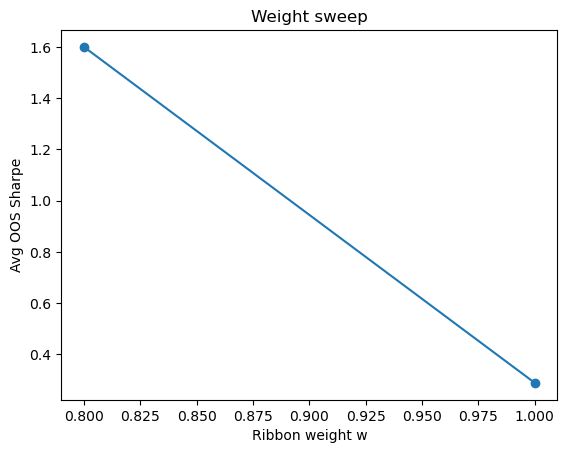

In [65]:
# Example: plot Sharpe vs weight for one pair

strategy_cond = (df_weight_profile['mavg_strategy'] == 'f16_s224_n8') & (df_weight_profile['donchian_strategy'] == 'en28_ex14_gFalse')
pair = df_weight_profile[strategy_cond]
# pair = df_weight_profile.query("mavg_strategy == 'f16_s224_n8' & donchian_strategy == 'en40_ex20_gFalse'")
plt.plot(pair["mavg_ribbon_weight"], pair["mean_sharpe"], marker="o")
plt.xlabel("Ribbon weight w"); plt.ylabel("Avg OOS Sharpe"); plt.title("Weight sweep")
plt.show()

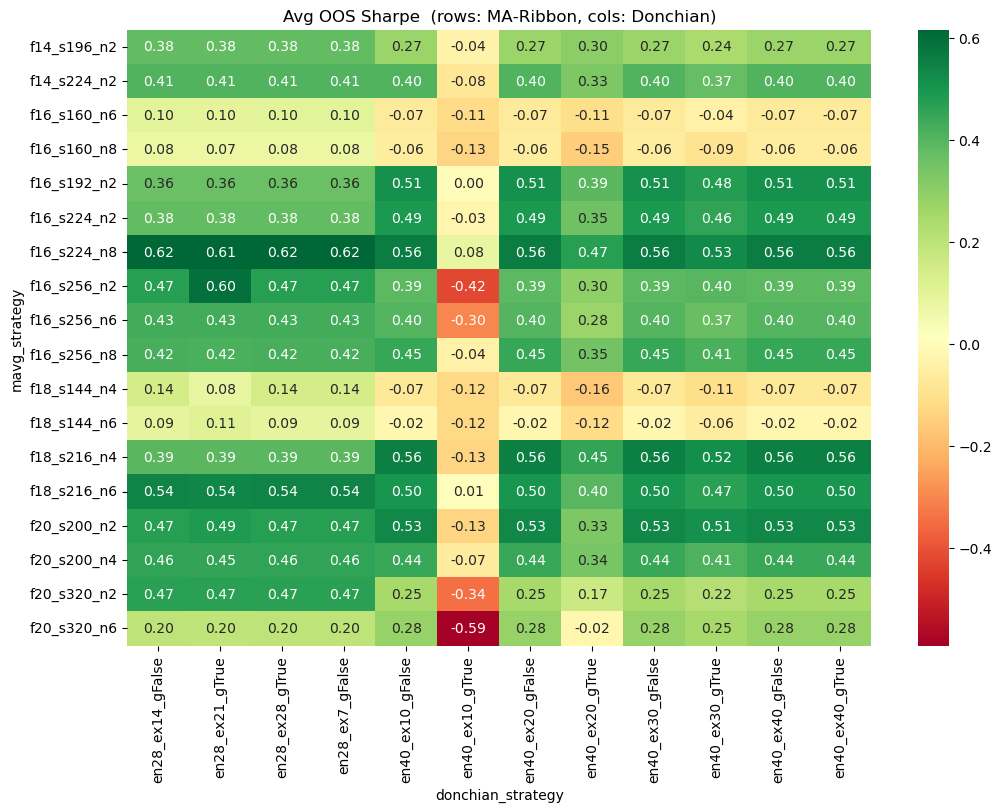

In [67]:
heat = df_performance_os_strategy_performance.pivot_table(
        index="mavg_strategy",
        columns="donchian_strategy",
        values="sharpe_mean")

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Avg OOS Sharpe  (rows: MA‑Ribbon, cols: Donchian)")
plt.show()

In [69]:
coin_cols = [c for c in df_performance_os.columns if c.endswith("_annualized_sharpe_ratio")]

coin_sharpe = (
    df_performance_os
    .groupby(["mavg_strategy", "donchian_strategy"])[coin_cols]
    .mean()
)

# Add the average cross‑coin dispersion
coin_sharpe["coin_sharpe_stdev"] = coin_sharpe.std(axis=1)
df_performance_os_strategy_performance = df_performance_os_strategy_performance.merge(coin_sharpe["coin_sharpe_stdev"],
                                                                                      on=["mavg_strategy","donchian_strategy"])

In [71]:
df_performance_os_strategy_performance.sort_values('strategy_score', ascending=False)

mavg_strategy donchian_strategy  sharpe_mean  sharpe_std  max_dd_mean  \
74    f16_s224_n8   en28_ex28_gTrue     0.616187    1.115842    -0.256440   
75    f16_s224_n8   en28_ex7_gFalse     0.616187    1.115842    -0.256440   
72    f16_s224_n8  en28_ex14_gFalse     0.616187    1.115842    -0.256440   
148   f18_s216_n4  en40_ex10_gFalse     0.555375    0.997791    -0.254732   
150   f18_s216_n4  en40_ex20_gFalse     0.555375    0.997791    -0.254732   
152   f18_s216_n4  en40_ex30_gFalse     0.555375    0.997791    -0.254732   
154   f18_s216_n4  en40_ex40_gFalse     0.555375    0.997791    -0.254732   
155   f18_s216_n4   en40_ex40_gTrue     0.555375    0.997791    -0.254732   
73    f16_s224_n8   en28_ex21_gTrue     0.613305    1.116763    -0.256440   
153   f18_s216_n4   en40_ex30_gTrue     0.521700    0.958558    -0.258644   
177   f20_s200_n2   en40_ex30_gTrue     0.510015    0.942695    -0.261798   
179   f20_s200_n2   en40_ex40_gTrue     0.534142    0.995425    -0.259785   
172   f20_s200_n2  en40_ex10_gFalse     0.534142    0.995425    -0.259785   
174   f20_s200_n2  en40_ex20_gFalse     0.534142    0.995425    -0.259785   
178   f20_s200_n2  en40_ex40_gFalse     0.534142    0.995425    -0.259785   
176   f20_s200_n2  en40_ex30_gFalse     0.534142    0.995425    -0.259785   
85    f16_s256_n2   en28_ex21_gTrue     0.596017    1.222253    -0.238301   
80    f16_s224_n8  en40_ex30_gFalse     0.563375    1.127692    -0.257145   
76    f16_s224_n8  en40_ex10_gFalse     0.563375    1.127692    -0.257145   
83    f16_s224_n8   en40_ex40_gTrue     0.563375    1.127692    -0.257145   
82    f16_s224_n8  en40_ex40_gFalse     0.563375    1.127692    -0.257145   
78    f16_s224_n8  en40_ex20_gFalse     0.563375    1.127692    -0.257145   
169   f20_s200_n2   en28_ex21_gTrue     0.487901    0.980311    -0.259633   
151   f18_s216_n4   en40_ex20_gTrue     0.453019    0.897845    -0.266255   
156   f18_s216_n6  en28_ex14_gFalse     0.541819    1.100087    -0.263107   
158   f18_s216_n6   en28_ex28_gTrue     0.541819    1.100087    -0.263107   
159   f18_s216_n6   en28_ex7_gFalse     0.541819    1.100087    -0.263107   
157   f18_s216_n6   en28_ex21_gTrue     0.538457    1.099705    -0.263107   
81    f16_s224_n8   en40_ex30_gTrue     0.529655    1.088722    -0.261161   
168   f20_s200_n2  en28_ex14_gFalse     0.473456    1.011354    -0.261703   
170   f20_s200_n2   en28_ex28_gTrue     0.473456    1.011354    -0.261703   
171   f20_s200_n2   en28_ex7_gFalse     0.473456    1.011354    -0.261703   
166   f18_s216_n6  en40_ex40_gFalse     0.499237    1.097429    -0.261169   
162   f18_s216_n6  en40_ex20_gFalse     0.499237    1.097429    -0.261169   
160   f18_s216_n6  en40_ex10_gFalse     0.499237    1.097429    -0.261169   
164   f18_s216_n6  en40_ex30_gFalse     0.499237    1.097429    -0.261169   
167   f18_s216_n6   en40_ex40_gTrue     0.499237    1.097429    -0.261169   
79    f16_s224_n8   en40_ex20_gTrue     0.472523    1.039527    -0.267009   
119   f16_s256_n8   en40_ex40_gTrue     0.446919    1.011974    -0.259188   
118   f16_s256_n8  en40_ex40_gFalse     0.446919    1.011974    -0.259188   
112   f16_s256_n8  en40_ex10_gFalse     0.446919    1.011974    -0.259188   
114   f16_s256_n8  en40_ex20_gFalse     0.446919    1.011974    -0.259188   
116   f16_s256_n8  en40_ex30_gFalse     0.446919    1.011974    -0.259188   
165   f18_s216_n6   en40_ex30_gTrue     0.465827    1.059655    -0.265045   
117   f16_s256_n8   en40_ex30_gTrue     0.413791    0.970928    -0.263136   
180   f20_s200_n4  en28_ex14_gFalse     0.457735    1.042277    -0.275206   
182   f20_s200_n4   en28_ex28_gTrue     0.457735    1.042277    -0.275206   
183   f20_s200_n4   en28_ex7_gFalse     0.457735    1.042277    -0.275206   
181   f20_s200_n4   en28_ex21_gTrue     0.454359    1.041211    -0.275206   
110   f16_s256_n8   en28_ex28_gTrue     0.419897    1.012200    -0.266133   
111   f16_s256_n8   en28_ex7_gFalse     0.419897    1.012200    -0.266133   


In [73]:
final = (
    df_performance_os_strategy_performance
    .query("sharpe_mean > 1.0")           # your hurdle
    .query("max_dd_mean > -0.45")            # max 45 % drawdown
    .sort_values(["strategy_score", "coin_sharpe_stdev"], ascending=[False, True])
)

final.head(10)[["mavg_strategy","donchian_strategy","sharpe_mean","max_dd_mean","strategy_score"]]

Empty DataFrame
Columns: [mavg_strategy, donchian_strategy, sharpe_mean, max_dd_mean, strategy_score]
Index: []

In [ ]:
df_weight_profile[strategy_cond]

In [ ]:
pair

In [ ]:
df_performance_os_strategy_performance.nlargest(5, 'strategy_score')[['mavg_strategy','donchian_strategy']]

In [ ]:
df_performance_os[(df_performance_os.mavg_strategy == 'f16_s224_n8') & (df_performance_os.donchian_strategy == 'en28_ex28_gTrue')]

In [ ]:
df_performance_is_strategy_performance[(df_performance_is_strategy_performance.mavg_strategy == 'f16_s224_n8') & (df_performance_is_strategy_performance.donchian_strategy == 'en28_ex28_gTrue')]

## Walk Forward Analysis with Only Best Pairs

In [43]:
import itertools

def generate_mavg_ribbon_donchian_channel_params():
    parameter_grid = {
        "mavg_ribbon_strategy": ['f16_s224_n2','f16_s224_n4','f16_s224_n6','f16_s224_n8','f18_s216_n2','f18_s216_n4','f18_s216_n6','f18_s216_n8'],
        "donchian_channel_strategy": ['en28_ex7_gFalse','en28_ex14_gFalse','en28_ex21_gFalse','en28_ex28_gFalse',
                                      'en28_ex7_gTrue','en28_ex14_gTrue','en28_ex21_gTrue','en28_ex28_gTrue',
                                      'en40_ex10_gFalse','en40_ex20_gFalse','en40_ex30_gFalse','en40_ex40_gFalse',
                                      'en40_ex10_gTrue','en40_ex20_gTrue','en40_ex30_gTrue','en40_ex40_gTrue']
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [45]:
def run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight', 'donchian_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
    
        for params in generate_mavg_ribbon_donchian_channel_params():
            print(params)
            mavg_strategy_params = params['mavg_ribbon_strategy']
            donchian_strategy_params = params['donchian_channel_strategy']
            
            ## Moving Average Ribbon Params
            fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
            slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
            mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
            
            ## Donchian Channel Params
            entry_window = int(donchian_strategy_params.split('_')[0][2:])
            exit_window = int(donchian_strategy_params.split('_')[1][2:])
            exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])
            
            print(mavg_strategy_params, donchian_strategy_params)
            print(fast_mavg, slow_mavg, mavg_stepsize, entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            for w in np.linspace(0, 1, 11):
                w_mavg = round(w, 2)
                w_donchian = round(1 - round(w, 2), 2)
                print(f'M Avg Ribbon Weight: {w_mavg}, Donchian Channel Weight: {w_donchian}')
                df_is = apply_target_volatility_position_sizing_continuous_strategy(
                    start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, long_only=long_only,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
                print('Calculating In Sample Asset Returns!!')
                df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

                ## In Sample Performance Metrics
                print('Getting In Sample Performance Metrics!!')
                row_parameters_is = {
                    'sampling_category': 'in_sample',
                    'start_date': start_date_is,
                    'end_date': end_date_is,
                    'mavg_strategy': mavg_strategy_params,
                    'donchian_strategy': donchian_strategy_params,
                    'mavg_ribbon_weight': w_mavg,
                    'donchian_weight': w_donchian
                }
                portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                   strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                   passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

                print('Getting In Sample Asset Performance!!')
                for ticker in ticker_list:
                    ## In Sample
                    ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                         strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                         annual_trading_days=365, include_transaction_costs_and_fees=False)
                    ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                    ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                    portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
                
                row_parameters_is.update(portfolio_perf_metrics_is)
    
                ## Assign in sample metrics to performance dataframe
                df_performance.loc[df_performance.shape[0]] = row_parameters_is

            ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
            in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
            strategy_cond = (df_performance['mavg_strategy'] == mavg_strategy_params) & (df_performance['donchian_strategy'] == donchian_strategy_params)
            date_cond = (df_performance['start_date'] == start_date_is) & (df_performance['end_date'] == end_date_is)
            best_in_sample_mavg_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['mavg_ribbon_weight'].iloc[0]
            best_in_sample_donchian_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_weight'].iloc[0]
            
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=best_in_sample_mavg_weight, donchian_signal_weight=best_in_sample_donchian_weight, 
                long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'mavg_strategy': mavg_strategy_params,
                'donchian_strategy': donchian_strategy_params,
                'mavg_ribbon_weight': best_in_sample_mavg_weight,
                'donchian_weight': best_in_sample_donchian_weight
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [47]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-06-30').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(years=2)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date:
        break
    start_date_is = (start_date_is + OS_LEN).date()

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
In Sample Start: 2023-06-01, In Sample End: 2025-05-31, Out of Sample Start: 2025-06-01, Out of Sample End: 2025-11-30


In [81]:
%%time
df_performance_1 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [82]:
df_performance_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance-2021-06-01-2023-11-30.pickle')

In [83]:
%%time
df_performance_2 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2021-12-01', end_date='2024-05-31', ticker_list=ticker_list)

In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [84]:
df_performance_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2021-12-01-2024-05-31.pickle')

In [85]:
%%time
df_performance_3 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2022-06-01', end_date='2024-11-30', ticker_list=ticker_list)

In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [86]:
df_performance_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2022-06-01-2024-11-30.pickle')

In [87]:
%%time
df_performance_4 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2022-12-01', end_date='2025-05-31', ticker_list=ticker_list)

In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [88]:
df_performance_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2022-12-01-2025-05-31.pickle')

In [99]:
df_performance = pd.concat([df_performance_1, df_performance_2, df_performance_3, df_performance_4], axis=0, ignore_index=True)

In [105]:
df_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2021-06-01-2025-05-31.pickle')

In [103]:
df_performance.shape

(6144, 37)

## Analyze Performance of Walk Forward Analysis

In [49]:
df_performance = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2021-06-01-2025-05-31.pickle')

In [51]:
os_cond = (df_performance['sampling_category'] == 'out_sample')
df_performance_os = df_performance[os_cond].reset_index(drop=True)
df_performance_is = df_performance[~os_cond].reset_index(drop=True)

In [53]:
import re

def parse_ma(s):
    # e.g. 'f16_s224_n8'
    fast  = int(re.search(r"f(\d+)", s).group(1))
    slow  = int(re.search(r"s(\d+)", s).group(1))
    step  = int(re.search(r"n(\d+)", s).group(1))
    return fast, slow, step

def parse_don(s):
    # e.g. 'en28_ex14_gTrue'
    entry  = int(re.search(r"en(\d+)", s).group(1))
    exit_  = int(re.search(r"ex(\d+)", s).group(1))
    gate   = re.search(r"g(True|False)", s).group(1) == "True"
    return entry, exit_, gate

In [55]:
## Out of Sample
df_performance_os[["fast","slow","step"]] = list(df_performance_os["mavg_strategy"].map(parse_ma))
df_performance_os[["entry","exit","gate"]] = list(df_performance_os["donchian_strategy"].map(parse_don))

# Your two clusters label
df_performance_os["cluster"] = np.where((df_performance_os["fast"]==16)&(df_performance_os["slow"]==224), "MA_16_224", "MA_18_216")

## In-Sample
df_performance_is[["fast","slow","step"]] = list(df_performance_is["mavg_strategy"].map(parse_ma))
df_performance_is[["entry","exit","gate"]] = list(df_performance_is["donchian_strategy"].map(parse_don))

# Your two clusters label
df_performance_is["cluster"] = np.where((df_performance_is["fast"]==16)&(df_performance_is["slow"]==224), "MA_16_224", "MA_18_216")

In [57]:
df_performance_os[(df_performance_os.cluster == 'MA_16_224') & (df_performance_os.donchian_strategy == 'en28_ex28_gFalse')]#.head(20)

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
3          out_sample  2023-06-01  2023-11-30   f16_s224_n2  en28_ex28_gFalse   
19         out_sample  2023-06-01  2023-11-30   f16_s224_n4  en28_ex28_gFalse   
35         out_sample  2023-06-01  2023-11-30   f16_s224_n6  en28_ex28_gFalse   
51         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
131        out_sample  2023-12-01  2024-05-31   f16_s224_n2  en28_ex28_gFalse   
147        out_sample  2023-12-01  2024-05-31   f16_s224_n4  en28_ex28_gFalse   
163        out_sample  2023-12-01  2024-05-31   f16_s224_n6  en28_ex28_gFalse   
179        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
259        out_sample  2024-06-01  2024-11-30   f16_s224_n2  en28_ex28_gFalse   
275        out_sample  2024-06-01  2024-11-30   f16_s224_n4  en28_ex28_gFalse   
291        out_sample  2024-06-01  2024-11-30   f16_s224_n6  en28_ex28_gFalse   
307        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
387        out_sample  2024-12-01  2025-05-31   f16_s224_n2  en28_ex28_gFalse   
403        out_sample  2024-12-01  2025-05-31   f16_s224_n4  en28_ex28_gFalse   
419        out_sample  2024-12-01  2025-05-31   f16_s224_n6  en28_ex28_gFalse   
435        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   

     mavg_ribbon_weight  donchian_weight  annualized_return  \
3                   0.8              0.2           0.801242   
19                  0.7              0.3           0.860149   
35                  0.7              0.3           0.739236   
51                  0.8              0.2           0.876251   
131                 0.2              0.8          -0.091100   
147                 1.0              0.0           0.226841   
163                 1.0              0.0           0.234574   
179                 1.0              0.0           0.104999   
259                 1.0              0.0           0.891432   
275                 0.9              0.1           1.118257   
291                 1.0              0.0           0.678979   
307                 1.0              0.0           0.823386   
387                 0.9              0.1          -0.301116   
403                 0.9              0.1          -0.297728   
419                 1.0              0.0          -0.191689   
435                 1.0              0.0          -0.189130   

     annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
3                   1.487868      2.544371            0.514749     -0.314908   
19                  1.573722      2.905780            0.510603     -0.296013   
35                  1.406795      2.320305            0.510115     -0.318594   
51                  1.599653      2.921789            0.500732     -0.299902   
131                -0.057105     -0.376981            0.586666     -0.241656   
147                 0.559869      0.856639            0.595524     -0.264804   
163                 0.572324      0.887451            0.601853     -0.264324   
179                 0.352771      0.397185            0.606666     -0.264357   
259                 1.459133      3.487521            0.613628     -0.255606   
275                 1.701801      4.362815            0.618391     -0.256315   
291                 1.198465      2.340660            0.612466     -0.290080   
307                 1.360579      2.834063            0.616417     -0.290532   
387                -1.368791     -1.522907            0.485541     -0.197725   
403                -1.331301     -1.500316            0.494248     -0.198444   
419                -0.866479     -1.117252            0.465081     -0.171572   
435                -0.848256     -1.106217            0.471063     -0.170970   

    max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
3                110 days  0.351852     1.068363  0.286956        234.0   
19               108 days  0.358025     1.1

In [59]:
## Top 15 Out of Sample Strategy Performance
group_cols = ["cluster","entry","exit","gate","step"]

df_performance_summary_os = (
    df_performance_os.groupby(group_cols)
    .agg(
        mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"),
    )
    .reset_index()
)

## Get the Standard Deviation of the per Coin Sharpe Ratios
coin_cols = [c for c in df_performance_os.columns if c.endswith("_annualized_sharpe_ratio")]
coin_disp = (df_performance_os.groupby(group_cols)[coin_cols].mean().std(axis=1)
             .rename("coin_sharpe_std").reset_index())
df_performance_summary_os = pd.merge(df_performance_summary_os, coin_disp, on=group_cols, how='left')

# A composite score that rewards level + stability + shallower DD, penalises turnover
lam_std, lam_dd, lam_turn = 0.5, 0.1, 1e-4  # tune lam_turn to your fee model
df_performance_summary_os["strategy_score"] = (
    df_performance_summary_os["mean_sharpe"] - lam_std * df_performance_summary_os["sharpe_std"]
    + lam_dd  * df_performance_summary_os["worst_dd"]      # DD is negative; adding improves score when less negative
    - lam_turn* df_performance_summary_os["mean_trade_count"]
)

df_performance_summary_os = df_performance_summary_os.sort_values("strategy_score", ascending=False)
df_performance_summary_os.head(15)


cluster  entry  exit   gate  step  mean_sharpe  sharpe_std  \
26   MA_16_224     28    28  False     6     0.577777    1.026065   
2    MA_16_224     28     7  False     6     0.577777    1.026065   
30   MA_16_224     28    28   True     6     0.577777    1.026065   
18   MA_16_224     28    21  False     6     0.577777    1.026065   
10   MA_16_224     28    14  False     6     0.577777    1.026065   
22   MA_16_224     28    21   True     6     0.574293    1.026114   
27   MA_16_224     28    28  False     8     0.616187    1.115842   
3    MA_16_224     28     7  False     8     0.616187    1.115842   
31   MA_16_224     28    28   True     8     0.616187    1.115842   
19   MA_16_224     28    21  False     8     0.616187    1.115842   
11   MA_16_224     28    14  False     8     0.616187    1.115842   
113  MA_18_216     40    30  False     4     0.555375    0.997791   
97   MA_18_216     40    10  False     4     0.555375    0.997791   
121  MA_18_216     40    40  False     4     0.555375    0.997791   
105  MA_18_216     40    20  False     4     0.555375    0.997791   

     worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
26      -0.866479            0.75 -0.318594 -0.261142     0.365275   
2       -0.866479            0.75 -0.318594 -0.261142     0.365275   
30      -0.866479            0.75 -0.318594 -0.261142     0.365275   
18      -0.866479            0.75 -0.318594 -0.261142     0.365275   
10      -0.866479            0.75 -0.318594 -0.261142     0.365275   
22      -0.866479            0.75 -0.318594 -0.261142     0.363104   
27      -0.848256            0.75 -0.299902 -0.256440     0.403877   
3       -0.848256            0.75 -0.299902 -0.256440     0.403877   
31      -0.848256            0.75 -0.299902 -0.256440     0.403877   
19      -0.848256            0.75 -0.299902 -0.256440     0.403877   
11      -0.848256            0.75 -0.299902 -0.256440     0.403877   
113     -0.824056            0.75 -0.301974 -0.254732     0.327550   
97      -0.824056            0.75 -0.301974 -0.254732     0.327550   
121     -0.824056            0.75 -0.301974 -0.254732     0.327550   
105     -0.824056            0.75 -0.301974 -0.254732     0.327550   

     mean_trade_count  coin_sharpe_std  strategy_score  
26             205.50         0.271672        0.012335  
2              205.50         0.271672        0.012335  
30             205.50         0.271672        0.012335  
18             205.50         0.271672        0.012335  
10             205.50         0.271672        0.012335  
22             205.50         0.271568        0.008827  
27             200.50         0.168002        0.008226  
3              200.50         0.168002        0.008226  
31             200.50         0.168002        0.008226  
19             200.50         0.168002        0.008226  
11             200.50         0.168002        0.008226  
113            182.75         0.320715        0.008007  
97             182.75         0.320715        0.008007  
121            182.75         0.320715        0.008007  
105            182.75         0.320715        0.008007

In [61]:
## Analyze the performance of Donchian Exit Gate
df_donchian_gate_performance = (
    df_performance_os
    .groupby(["cluster","entry","exit","step","gate"])["annualized_sharpe_ratio"]
    .mean()
    .unstack("gate")  # columns: False/True
    .dropna()
    .rename(columns={False:"no_gate", True:"gate"})
)

df_donchian_gate_performance["gate_lift"] = df_donchian_gate_performance["gate"] - df_donchian_gate_performance["no_gate"]
df_donchian_gate_performance.sort_values("gate_lift", ascending=False)#.head(10)

# For most clusters, performance is flat or worse, adding a gate leads to performance drag

gate                        no_gate      gate  gate_lift
cluster   entry exit step                               
MA_18_216 28    14   2     0.428080  0.446562   0.018482
          40    40   8     0.606049  0.606049   0.000000
MA_16_224 28    28   6     0.577777  0.577777   0.000000
MA_18_216 28    28   8     0.515582  0.515582   0.000000
                     6     0.541819  0.541819   0.000000
                     4     0.393420  0.393420   0.000000
                     2     0.428080  0.428080   0.000000
          40    40   4     0.555375  0.555375   0.000000
MA_16_224 40    40   8     0.563375  0.563375   0.000000
MA_18_216 40    40   2     0.464214  0.464214   0.000000
MA_16_224 40    40   4     0.594799  0.594799   0.000000
                     2     0.489711  0.489711   0.000000
          28    28   8     0.616187  0.616187   0.000000
          40    40   6     0.528383  0.528383   0.000000
          28    28   4     0.626023  0.626023   0.000000
MA_18_216 40    40   6     0.499237  0.499237   0.000000
MA_16_224 28    28   2     0.380277  0.380277   0.000000
                21   2     0.380277  0.379206  -0.001070
MA_18_216 28    21   4     0.393420  0.392302  -0.001117
MA_16_224 28    21   8     0.616187  0.613305  -0.002882
MA_18_216 28    21   6     0.541819  0.538457  -0.003362
                     8     0.515582  0.512217  -0.003364
MA_16_224 28    21   6     0.577777  0.574293  -0.003483
MA_18_216 28    21   2     0.428080  0.424515  -0.003565
          40    30   2     0.464214  0.432469  -0.031745
MA_16_224 40    30   4     0.594799  0.562763  -0.032035
                     2     0.489711  0.457558  -0.032153
                     6     0.528383  0.495971  -0.032412
MA_18_216 40    30   6     0.499237  0.465827  -0.033410
                     4     0.555375  0.521700  -0.033674
MA_16_224 40    30   8     0.563375  0.529655  -0.033720
MA_18_216 40    30   8     0.606049  0.572160  -0.033889
                20   2     0.464214  0.393073  -0.071141
MA_16_224 28    14   6     0.577777  0.488182  -0.089595
                     8     0.616187  0.526348  -0.089838
MA_18_216 28    14   8     0.515582  0.425728  -0.089854
MA_16_224 40    20   8     0.563375  0.472523  -0.090852
          28    14   2     0.380277  0.288706  -0.091571
          40    20   4     0.594799  0.502639  -0.092160
                     6     0.528383  0.433522  -0.094861
MA_18_216 28    14   6     0.541819  0.446857  -0.094962
                     4     0.393420  0.294645  -0.098774
          40    20   6     0.499237  0.397842  -0.101395
                     4     0.555375  0.453019  -0.102355
                     8     0.606049  0.503291  -0.102759
MA_16_224 40    20   2     0.489711  0.354872  -0.134839
          28    21   4     0.626023  0.469710  -0.156313
                14   4     0.626023  0.378807  -0.247215
          40    10   4     0.594799  0.283280  -0.311518
MA_18_216 40    10   2     0.464214 -0.015910  -0.480124
MA_16_224 40    10   8     0.563375  0.078951  -0.484424
                     6     0.528383  0.043447  -0.484936
MA_18_216 40    10   6     0.499237  0.006463  -0.492774
MA_16_224 40    10   2     0.489711 -0.025492  -0.515204
MA_18_216 28    7    4     0.393420 -0.151235  -0.544654
          40    10   8     0.606049  0.053269  -0.552780
                     4     0.555375 -0.130573  -0.685948
          28    7    8     0.515582 -0.181848  -0.697430
                     6     0.541819 -0.172987  -0.714806
MA_16_224 28    7    8     0.616187 -0.104291  -0.720478
MA_18_216 28    7    2     0.428080 -0.430888  -0.858968
MA_16_224 28    7    2     0.380277 -0.513166  -0.893442
                     6     0.577777 -0.366130  -0.943906
                     4     0.626023 -0.505376  -1.131398

In [63]:
## Correlation Sharpe vs trade_count per (cluster, entry, exit, gate)
## Identify the general correlation trend between Sharpe Ratio and Average Trade Count
df_correlation_sharpe_stepsize = (
    df_performance_summary_os
    .groupby(["cluster","entry","exit","gate"])
    .apply(lambda g: g["mean_sharpe"].corr(g["mean_trade_count"]))
    .rename("corr_sharpe_turnover")
    .reset_index()
)

def get_mavg_stepsize_performance(df_performance_summary_os):

    ## Define Moving Average Ribbon Stepsize Strategy Score
    EPS = 0.05
    L_STD, L_DD, L_TURN, L_DISP = 0.5, 0.10, 1e-4, 0.20   # tune to taste

    ## Create a group by Cluster parameters without gate
    groupby_cols = ["cluster","entry","exit","gate"]
    df_mavg_stepsize_group = df_performance_summary_os.groupby(groupby_cols)
    
    ## Get the Best Sharpe
    best_stepsize_sharpe = max(df_mavg_stepsize_group["mean_sharpe"].max())
    
    ## Get all cluster combinations within (EPS = 0.05) of the Best Sharpe
    best_stepsize_sharpe_cond = (df_performance_summary_os["mean_sharpe"] >= best_stepsize_sharpe - EPS)
    df_best_stepsize_sharpe = df_performance_summary_os[best_stepsize_sharpe_cond].reset_index(drop=True)
    
    df_best_stepsize_sharpe["mavg_stepsize_score"] = (df_best_stepsize_sharpe["mean_sharpe"]
                                                      - L_STD  * df_best_stepsize_sharpe["sharpe_std"]
                                                      + L_DD   * df_best_stepsize_sharpe["worst_dd"]   # DD is negative; less negative improves score
                                                      - L_TURN * df_best_stepsize_sharpe["mean_trade_count"]
                                                      - L_DISP * df_best_stepsize_sharpe["coin_sharpe_std"])
    df_best_stepsize_sharpe = df_best_stepsize_sharpe.sort_values(["mavg_stepsize_score","mean_trade_count","step"], ascending=[False, True, True])

    return df_best_stepsize_sharpe

In [65]:
df_best_stepsize_sharpe = get_mavg_stepsize_performance(df_performance_summary_os)
df_best_stepsize_sharpe

## Stepsize of 8 has the best performance

cluster  entry  exit   gate  step  mean_sharpe  sharpe_std  \
5   MA_16_224     28    28  False     8     0.616187    1.115842   
6   MA_16_224     28     7  False     8     0.616187    1.115842   
7   MA_16_224     28    28   True     8     0.616187    1.115842   
8   MA_16_224     28    21  False     8     0.616187    1.115842   
9   MA_16_224     28    14  False     8     0.616187    1.115842   
10  MA_16_224     28    21   True     8     0.613305    1.116763   
0   MA_16_224     28    28  False     6     0.577777    1.026065   
1   MA_16_224     28     7  False     6     0.577777    1.026065   
2   MA_16_224     28    28   True     6     0.577777    1.026065   
3   MA_16_224     28    21  False     6     0.577777    1.026065   
4   MA_16_224     28    14  False     6     0.577777    1.026065   
11  MA_18_216     40    30  False     8     0.606049    1.198738   
12  MA_18_216     40    20  False     8     0.606049    1.198738   
13  MA_18_216     40    10  False     8     0.606049    1.198738   
14  MA_18_216     40    40   True     8     0.606049    1.198738   
15  MA_18_216     40    40  False     8     0.606049    1.198738   
16  MA_16_224     28     7  False     4     0.626023    1.401300   
17  MA_16_224     28    28  False     4     0.626023    1.401300   
18  MA_16_224     28    28   True     4     0.626023    1.401300   
19  MA_16_224     28    14  False     4     0.626023    1.401300   
20  MA_16_224     28    21  False     4     0.626023    1.401300   
21  MA_16_224     40    30  False     4     0.594799    1.434517   
22  MA_16_224     40    20  False     4     0.594799    1.434517   
23  MA_16_224     40    10  False     4     0.594799    1.434517   
24  MA_16_224     40    40   True     4     0.594799    1.434517   
25  MA_16_224     40    40  False     4     0.594799    1.434517   

    worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
5      -0.848256            0.75 -0.299902 -0.256440     0.403877   
6      -0.848256            0.75 -0.299902 -0.256440     0.403877   
7      -0.848256            0.75 -0.299902 -0.256440     0.403877   
8      -0.848256            0.75 -0.299902 -0.256440     0.403877   
9      -0.848256            0.75 -0.299902 -0.256440     0.403877   
10     -0.848256            0.75 -0.299902 -0.256440     0.402219   
0      -0.866479            0.75 -0.318594 -0.261142     0.365275   
1      -0.866479            0.75 -0.318594 -0.261142     0.365275   
2      -0.866479            0.75 -0.318594 -0.261142     0.365275   
3      -0.866479            0.75 -0.318594 -0.261142     0.365275   
4      -0.866479            0.75 -0.318594 -0.261142     0.365275   
11     -1.035493            0.75 -0.289871 -0.250694     0.400614   
12     -1.035493            0.75 -0.289871 -0.250694     0.400614   
13     -1.035493            0.75 -0.289871 -0.250694     0.400614   
14     -1.035493            0.75 -0.289871 -0.250694     0.400614   
15     -1.035493            0.75 -0.289871 -0.250694     0.400614   
16     -1.331301            0.75 -0.296013 -0.253894     0.476880   
17     -1.331301            0.75 -0.296013 -0.253894     0.476880   
18     -1.331301            0.75 -0.296013 -0.253894     0.476880   
19     -1.331301            0.75 -0.296013 -0.253894     0.476880   
20     -1.331301            0.75 -0.296013 -0.253894     0.476880   
21     -1.342214            0.75 -0.310616 -0.258447     0.472136   
22     -1.342214            0.75 -0.310616 -0.258447     0.472136   
23     -1.342214            0.75 -0.310616 -0.258447     0.472136   
24     -1.342214            0.75 -0.310616 -0.258447     0.472136   
25     -1.342214            0.75 -0.310616 -0.258447     0.472136   

    mean_trade_count  coin_sharpe_std  strategy_score  mavg_stepsize_score  
5             200.50         0.168002        0.008226            -0.025375  
6             200.50         0.168002        0.008226            -0.025375  
7             200.50         0.168002        0.008226            -0.025375

In [67]:
df_correlation_sharpe_stepsize

cluster  entry  exit   gate  corr_sharpe_turnover
0   MA_16_224     28     7  False             -0.707128
1   MA_16_224     28     7   True             -0.979604
2   MA_16_224     28    14  False             -0.707128
3   MA_16_224     28    14   True             -0.756641
4   MA_16_224     28    21  False             -0.707128
5   MA_16_224     28    21   True             -0.764704
6   MA_16_224     28    28  False             -0.707128
7   MA_16_224     28    28   True             -0.707128
8   MA_16_224     40    10  False             -0.510624
9   MA_16_224     40    10   True             -0.221066
10  MA_16_224     40    20  False             -0.510624
11  MA_16_224     40    20   True             -0.625536
12  MA_16_224     40    30  False             -0.510624
13  MA_16_224     40    30   True             -0.464466
14  MA_16_224     40    40  False             -0.510624
15  MA_16_224     40    40   True             -0.510624
16  MA_18_216     28     7  False             -0.996519
17  MA_18_216     28     7   True             -0.981287
18  MA_18_216     28    14  False             -0.996519
19  MA_18_216     28    14   True             -0.587628
20  MA_18_216     28    21  False             -0.996519
21  MA_18_216     28    21   True             -0.996404
22  MA_18_216     28    28  False             -0.996519
23  MA_18_216     28    28   True             -0.996519
24  MA_18_216     40    10  False             -0.591097
25  MA_18_216     40    10   True             -0.389347
26  MA_18_216     40    20  False             -0.591097
27  MA_18_216     40    20   True             -0.427279
28  MA_18_216     40    30  False             -0.591097
29  MA_18_216     40    30   True             -0.590881
30  MA_18_216     40    40  False             -0.591097
31  MA_18_216     40    40   True             -0.591097

In [69]:
## Decide on which entry gate to use for the Donchian Channel Signal
## Lock the Stepsize to 8 and gate to False
entry_cond = ((df_performance_os['gate'] == False) & (df_performance_os['step'].isin([6, 8])))
df_entry_gate_donchian_performance = (
    df_performance_os[entry_cond]
    .groupby(["cluster","entry"])
    .agg(mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"))
    .reset_index()
    .sort_values("mean_sharpe", ascending=False)
)
## Entry window of 28 has the best performance

In [71]:
df_entry_gate_donchian_performance

cluster  entry  mean_sharpe  sharpe_std  worst_sharpe  pos_sharpe_pct  \
0  MA_16_224     28     0.596982    0.943343     -0.866479            0.75   
3  MA_18_216     40     0.552643    1.012616     -1.035493            0.75   
1  MA_16_224     40     0.545879    0.946893     -0.866498            0.75   
2  MA_18_216     28     0.528700    0.956010     -1.035526            0.75   

   worst_dd   mean_dd  mean_return  mean_trade_count  
0 -0.318594 -0.258791     0.384576           203.000  
3 -0.301631 -0.255931     0.359230           180.750  
1 -0.317220 -0.258972     0.352089           183.625  
2 -0.336791 -0.265448     0.351333           196.250

## Walk Forward Analysis to Determine the Best Signal Weights for the Optimal Config
#### Cluster: MA_16_224, Donchian Entry Gate: 28, Donchian Exit Gate: False, Moving Average Stepsize: 8

In [175]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                           tanh_activation_constant_dict=None, 
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    # final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
    # if tanh_activation_constant_dict:
    #     k = tanh_activation_constant_dict[ticker]
    #     df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    # else:
    #     if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
    #         k = 1.0
    #     else:
    #         k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
    #     df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_weighted_additive_signal_col]), df_trend[final_weighted_additive_signal_col])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            tanh_activation_constant_dict=None, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [260]:
def run_walk_forward_mavg_ribbon_donchian_ribbon_weight_activation(start_date, end_date, ticker_list, use_activation=True):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight', 'donchian_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

    ## Define Production Config
    mavg_strategy = 'f16_s224_n8'
    donchian_strategy = 'en28_ex28_gFalse'
    # use_activation = False
    tanh_activation_constant_dict = None
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
    
        mavg_strategy_params = mavg_strategy
        donchian_strategy_params = donchian_strategy
        
        ## Moving Average Ribbon Params
        fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
        slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
        mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
        
        ## Donchian Channel Params
        entry_window = int(donchian_strategy_params.split('_')[0][2:])
        exit_window = int(donchian_strategy_params.split('_')[1][2:])
        exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])

        ## In Sample Dataframe
        print('Pulling In Sample Data!!')
        for w in np.linspace(0, 1, 11):
            w_mavg = round(w, 2)
            w_donchian = round(1 - round(w, 2), 2)
            print(f'M Avg Ribbon Weight: {w_mavg}, Donchian Channel Weight: {w_donchian}')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'mavg_strategy': mavg_strategy_params,
                'donchian_strategy': donchian_strategy_params,
                'mavg_ribbon_weight': w_mavg,
                'donchian_weight': w_donchian
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        strategy_cond = (df_performance['mavg_strategy'] == mavg_strategy_params) & (df_performance['donchian_strategy'] == donchian_strategy_params)
        date_cond = (df_performance['start_date'] == start_date_is) & (df_performance['end_date'] == end_date_is)
        best_in_sample_mavg_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['mavg_ribbon_weight'].iloc[0]
        best_in_sample_donchian_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_weight'].iloc[0]

        if use_activation:
            df_is_best = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=best_in_sample_mavg_weight, donchian_signal_weight=best_in_sample_donchian_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            
            final_weighted_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
            tanh_activation_constant_dict = {}
            for ticker in ticker_list:
                tanh_activation_constant_dict[ticker] = np.abs(df_is_best[f'{ticker}_final_weighted_additive_signal']).quantile(0.95)
        else:
            tanh_activation_constant_dict = None
        
        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        df_os = apply_target_volatility_position_sizing_continuous_strategy(
            start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
            use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=best_in_sample_mavg_weight, donchian_signal_weight=best_in_sample_donchian_weight,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
        
        ## Out of Sample Performance Metrics
        print('Pulling Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'mavg_strategy': mavg_strategy_params,
            'donchian_strategy': donchian_strategy_params,
            'mavg_ribbon_weight': best_in_sample_mavg_weight,
            'donchian_weight': best_in_sample_donchian_weight
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [258]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-06-30').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(years=2)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date:
        break
    start_date_is = (start_date_is + OS_LEN).date()

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
In Sample Start: 2023-06-01, In Sample End: 2025-05-31, Out of Sample Start: 2025-06-01, Out of Sample End: 2025-11-30


In [183]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-05-31').date()
df_performance_wo_activation = run_walk_forward_mavg_ribbon_donchian_ribbon_weight_activation(start_date, end_date, ticker_list)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight:

In [207]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-05-31').date()
df_performance_with_activation = run_walk_forward_mavg_ribbon_donchian_ribbon_weight_wo_activation(start_date, end_date, ticker_list)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight:

In [189]:
df_performance_wo_activation[df_performance_wo_activation.sampling_category == 'out_sample']

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
11        out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
23        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
35        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
47        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   

    mavg_ribbon_weight  donchian_weight  annualized_return  \
11                 0.8              0.2           0.864765   
23                 1.0              0.0           0.098834   
35                 1.0              0.0           0.814249   
47                 1.0              0.0          -0.188520   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
11                 1.579235      2.865979            0.497437     -0.301734   
23                 0.340544      0.376841            0.605176     -0.262269   
35                 1.352363      2.786983            0.619137     -0.292161   
47                -0.866742     -1.122679            0.450532     -0.167920   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
11              108 days  0.351852     1.129825  0.260231        255.0   
23               78 days  0.382716     0.291815  0.770804        259.0   
35              112 days  0.314815     0.966928  0.335030        204.0   
47              129 days  0.155280    -0.450611  0.652880        108.0   

    BTC-USD_annualized_return  ETH-USD_annualized_return  \
11                   0.104115                   0.061140   
23                   0.088248                   0.150301   
35                   0.159404                   0.144020   
47                   0.052647                  -0.004502   

    SOL-USD_annualized_return  ADA-USD_annualized_return  \
11                   0.497627                   0.237306   
23                   0.247618                  -0.058631   
35                  -0.101322                   0.239148   
47                  -0.088072                  -0.010277   

    AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
11                    0.086907                         0.624506   
23                   -0.074454                         0.283721   
35                    0.681630                         0.883207   
47                   -0.006991                         0.080525   

    ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
11                         0.177638                         1.307697   
23                         0.656842                         1.061497   
35                         1.348586                        -0.451625   
47                        -2.845591                        -1.844359   

    ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
11                         2.134983                          0.544719   
23                        -1.725559                         -2.269115   
35                         1.664751                          2.690985   
47                        -1.361269                         -0.926546   

    BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
11                    0.124665                    0.112834   
23                    0.234717                    0.196187   
35                    0.171432                    0.125414   
47                    0.205777                    0.052785   

    SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
11                    0.370881                    0.114130   
23                    0.211281                    0.102492   
35                    0.347878                    0.145586   
47                    0.130896                    0.094145   

    AVAX-USD_annualized_std_dev  BTC-USD_max_drawdown  ETH-USD_max_drawdown  \
11                     0.112141             -0.028673             -0.023116   
23                     0.095244             -0.117870             -0.084963   


In [211]:
df_performance_with_activation[df_performance_with_activation.sampling_category == 'out_sample']

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
11        out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
23        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
35        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
47        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   

    mavg_ribbon_weight  donchian_weight  annualized_return  \
11                 0.8              0.2           0.876251   
23                 1.0              0.0           0.104999   
35                 1.0              0.0           0.823386   
47                 1.0              0.0          -0.189130   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
11                 1.599653      2.921789            0.500732     -0.299902   
23                 0.352771      0.397185            0.606666     -0.264357   
35                 1.360579      2.834063            0.616417     -0.290532   
47                -0.848256     -1.106217            0.471063     -0.170970   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
11              108 days  0.351852     1.143802  0.254403        240.0   
23               78 days  0.388889     0.299585  0.764880        262.0   
35              111 days  0.314815     0.972250  0.332385        202.0   
47              129 days  0.155280    -0.440716  0.660013         98.0   

    BTC-USD_annualized_return  ETH-USD_annualized_return  \
11                   0.111854                   0.075470   
23                   0.068759                   0.145494   
35                   0.108214                   0.151670   
47                   0.040650                  -0.004303   

    SOL-USD_annualized_return  ADA-USD_annualized_return  \
11                   0.485116                   0.217032   
23                   0.286530                  -0.053618   
35                  -0.066128                   0.241630   
47                  -0.089643                  -0.002038   

    AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
11                    0.101563                         0.685398   
23                   -0.078150                         0.188140   
35                    0.703227                         0.506700   
47                   -0.002451                        -0.019961   

    ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
11                         0.342472                         1.293473   
23                         0.648112                         1.214807   
35                         1.367445                        -0.323817   
47                        -2.752010                        -1.736739   

    ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
11                         1.994596                          0.727494   
23                        -1.440665                         -2.061761   
35                         1.584704                          2.813036   
47                        -1.074303                         -0.796873   

    BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
11                    0.128797                    0.118699   
23                    0.226218                    0.189107   
35                    0.172256                    0.133516   
47                    0.197433                    0.054368   

    SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
11                    0.365990                    0.110041   
23                    0.215333                    0.116151   
35                    0.338505                    0.155484   
47                    0.140382                    0.102011   

    AVAX-USD_annualized_std_dev  BTC-USD_max_drawdown  ETH-USD_max_drawdown  \
11                     0.114648             -0.029075             -0.024241   
23                     0.107913             -0.116976             -0.079197   


In [213]:
df_performance_with_activation.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_With_Activation_Weight_Performance-2021-06-01-2025-05-31.pickle')
df_performance_wo_activation.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Wo_Activation_Weight_Performance-2021-06-01-2025-05-31.pickle')

In [ ]:
df_performance_with_activation = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_With_Activation_Weight_Performance-2021-06-01-2025-05-31.pickle')

In [161]:
## Without activation
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=None, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [171]:
## With activation
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=None, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


<Axes: xlabel='date'>

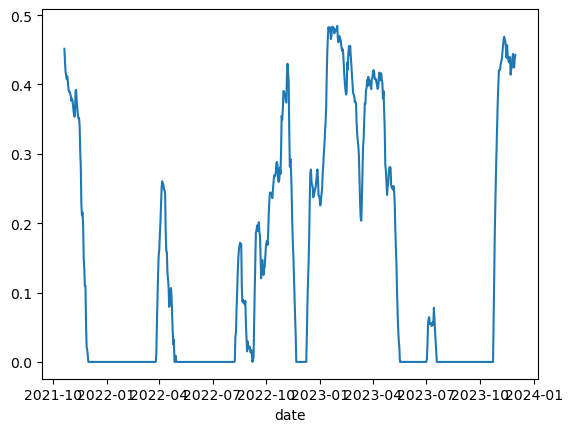

In [163]:
## Without Activation
df_is['BTC-USD_final_signal'].plot()

<Axes: xlabel='date'>

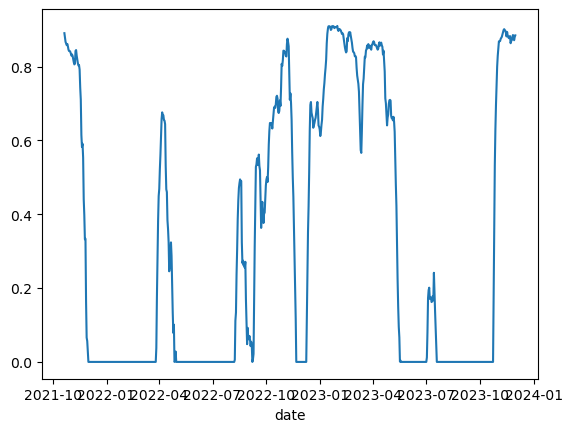

In [172]:
## With Activation
df_is['BTC-USD_final_signal'].plot()

In [155]:
df_is.head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2021-10-21                      3029.172671                          0.000000   
2021-10-22                      3178.856226                       4543.743741   
2021-10-23                      3233.250872                       4432.631533   
2021-10-24                      3125.322217                       4477.711038   
2021-10-25                      3015.202958                       4444.686287   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_20  \
date                                                                         
2021-10-21                      0.000000                          0.654385   
2021-10-22                      0.073046                          0.639165   
2021-10-23                      0.073046                          0.651724   
2021-10-24                      0.073046                          0.651816   
2021-10-25                      0.073046                          0.656002   

            BTC-USD_cash_shrink_factor  BTC-USD_close  \
date                                                    
2021-10-21                         0.0       62204.02   
2021-10-22                         0.0       60687.64   
2021-10-23                         0.0       61300.01   
2021-10-24                         0.0       60854.48   
2021-10-25                         0.0       63083.54   

            BTC-USD_cooldown_counter       BTC-USD_event  \
date                                                       
2021-10-21                       0.0                 NaN   
2021-10-22                       0.0   New Long Position   
2021-10-23                       0.0  Open Long Position   
2021-10-24                       0.0  Open Long Position   
2021-10-25                       0.0  Open Long Position   

            BTC-USD_final_signal  BTC-USD_final_weighted_additive_signal  \
date                                                                       
2021-10-21              0.451489                                0.451489   
2021-10-22              0.433038                                0.433038   
2021-10-23              0.418481                                0.418481   
2021-10-24              0.413344                                0.413344   
2021-10-25              0.407576                                0.407576   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2021-10-21                                   0.00   
2021-10-22                               62204.01   
2021-10-23                               60682.88   
2021-10-24                               61300.02   
2021-10-25                               60847.91   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2021-10-21                       0.000000                   0.000000   
2021-10-22                    4543.743741                   0.073046   
2021-10-23                       0.000000                   0.000000   
2021-10-24                       0.000000                   0.000000   
2021-10-25                       0.000000                   0.000000   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2021-10-21      66021.26                        0.000000   
2021-10-22      62204.01                        0.000000   
2021-10-23      60682.88                     4432.631533   
2021-10-24      61300.02                     4477.711038   
2021-10-25      60847.91                     4444.686287   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2021-10-21                    0.000000                          0.0   
2021-10-22                    0.

In [157]:
perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.23400134562743602,
 'annualized_sharpe_ratio': -0.47510497520815587,
 'calmar_ratio': -0.3280133746315728,
 'annualized_std_dev': 0.5652218255963256,
 'max_drawdown': -0.7133896472674877,
 'max_drawdown_duration': Timedelta('739 days 00:00:00'),
 'hit_rate': 0.3203631647211414,
 't_statistic': -0.5329376375777404,
 'p_value': 0.5942305209159131,
 'trade_count': 1054.0}

In [132]:
np.abs(df_is['BTC-USD_final_weighted_additive_signal']).quantile(0.95)

0.46594857579383253

In [108]:
np.abs(df_is['ETH-USD_final_weighted_additive_signal']).quantile(0.95)

0.4699992899434025

In [110]:
np.abs(df_is['ADA-USD_final_weighted_additive_signal']).quantile(0.95)

0.4706896393150276

In [112]:
np.abs(df_is['SOL-USD_final_weighted_additive_signal']).quantile(0.95)

0.47152392407208465

In [114]:
np.abs(df_is['AVAX-USD_final_weighted_additive_signal']).quantile(0.95)

0.47236458399095443

In [248]:
final_weighted_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
tanh_activation_constant_dict = {}
for ticker in ticker_list:
    tanh_activation_constant_dict[ticker] = np.abs(df_is[f'{ticker}_final_weighted_additive_signal']).quantile(0.95)

In [250]:
tanh_activation_constant_dict

{'BTC-USD': 0.46594857579383253,
 'ETH-USD': 0.4699992899434025,
 'SOL-USD': 0.47152392407208465,
 'ADA-USD': 0.4706896393150276,
 'AVAX-USD': 0.47254282901082484}

In [136]:
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [138]:
perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.23399189526878894,
 'annualized_sharpe_ratio': -0.47448346144804493,
 'calmar_ratio': -0.32790121104352055,
 'annualized_std_dev': 0.564685901685028,
 'max_drawdown': -0.7136048522789153,
 'max_drawdown_duration': Timedelta('739 days 00:00:00'),
 'hit_rate': 0.3203631647211414,
 't_statistic': -0.5321355580181899,
 'p_value': 0.5947856141730341,
 'trade_count': 1060.0}

In [388]:
## Decide on which entry gate to use for the Donchian Channel Signal
## Lock the Stepsize to 8 and gate to False
entry_cond = ((df_performance_os['cluster'] == 'MA_16_224') & (df_performance_os['entry'].isin([21, 28])) & (df_performance_os['gate'] == False) & (df_performance_os['step'].isin([6, 8])))
df_ma_ribbon_weight_performance = (
    df_performance_os[entry_cond]
    .groupby(["cluster","entry","step","mavg_ribbon_weight","donchian_weight"])
    .agg(mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"))
    .reset_index()
    .sort_values("mean_sharpe", ascending=False)
)
## Entry window of 28 has the best performance

In [390]:
df_ma_ribbon_weight_performance

cluster  entry  step  mavg_ribbon_weight  donchian_weight  mean_sharpe  \
2  MA_16_224     28     8                 0.8              0.2     1.599653   
0  MA_16_224     28     6                 0.7              0.3     1.406795   
1  MA_16_224     28     6                 1.0              0.0     0.301437   
3  MA_16_224     28     8                 1.0              0.0     0.288365   

   sharpe_std  worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
2    0.000000      1.599653        1.000000 -0.299902 -0.299902     0.876251   
0    0.000000      1.406795        1.000000 -0.318594 -0.318594     0.739236   
1    0.902938     -0.866479        0.666667 -0.290080 -0.241992     0.240621   
3    0.943051     -0.848256        0.666667 -0.290532 -0.241953     0.246418   

   mean_trade_count  
2        240.000000  
0        253.000000  
1        189.666667  
3        187.333333

In [362]:
# OOS only, fixed structure
filt = (df_performance_os["cluster"].eq("MA_16_224") &
        df_performance_os["entry"].eq(28) &
        df_performance_os["step"].eq(8) &
        df_performance_os["gate"].eq(False) &
        df_performance_os["exit"].isin([21, 28]))      # or include all exits you keep

w_profile = (df_performance_os.loc[filt]
             .groupby("mavg_ribbon_weight")["annualized_sharpe_ratio"]
             .agg(mean_sharpe="mean", worst="min", count="size")
             .sort_index())

print(w_profile)  # look for a broad top; 0.65–0.70 should stand out


                    mean_sharpe     worst  count
mavg_ribbon_weight                              
0.8                    1.599653  1.599653      2
1.0                    0.288365 -0.848256      6


In [372]:
filt = (df_performance_is["cluster"].eq("MA_16_224") &
        df_performance_is["entry"].eq(28) &
        df_performance_is["step"].eq(8) &
        df_performance_is["gate"].eq(False) &
        df_performance_is["exit"].isin([21, 28])) 

In [380]:
(df_performance_is[filt].groupby("mavg_ribbon_weight")["annualized_sharpe_ratio"]
 .agg(mean_sharpe="mean", worst="min", count="size")
 .sort_index())

mean_sharpe     worst  count
mavg_ribbon_weight                              
0.0                   -0.336300 -1.790570      8
0.1                   -0.339208 -1.533497      8
0.2                   -0.329561 -1.764056      8
0.3                   -0.357665 -1.570500      8
0.4                   -0.456633 -1.835694      8
0.5                   -0.182735 -1.338456      8
0.6                   -0.090852 -1.242756      8
0.7                    0.042317 -1.171769      8
0.8                    0.132148 -0.994416      8
0.9                    0.195636 -0.803920      8
1.0                    0.263339 -0.969117      8

In [115]:
df_performance.head()

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
0         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
1         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
2         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
3         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
4         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   

   mavg_ribbon_weight  donchian_weight  annualized_return  \
0                 0.0              1.0          -0.620453   
1                 0.1              0.9          -0.562871   
2                 0.2              0.8          -0.609231   
3                 0.3              0.7          -0.573392   
4                 0.4              0.6          -0.582723   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                -1.790570     -0.724938            0.605099     -0.855872   
1                -1.525900     -0.689592            0.601925     -0.816238   
2                -1.811975     -0.726001            0.589945     -0.839160   
3                -1.628057     -0.701307            0.591289     -0.817604   
4                -1.713242     -0.721869            0.577925     -0.807242   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              554 days  0.295918    -2.148274  0.032100        971.0   
1              568 days  0.301020    -1.811222  0.070618        937.0   
2              568 days  0.292517    -2.170978  0.030333        919.0   
3              568 days  0.295918    -1.937661  0.053144        931.0   
4              568 days  0.295918    -2.043427  0.041456        958.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                  -0.079120                   0.032138   
1                  -0.029747                   0.038420   
2                  -0.024450                   0.027445   
3                  -0.055202                   0.013657   
4                  -0.045804                   0.003794   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                  -0.133513                  -0.177671   
1                  -0.153291                  -0.155203   
2                  -0.129162                  -0.184051   
3                  -0.114844                  -0.100404   
4                  -0.081056                  -0.150840   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                   -0.019710                        -1.050796   
1                    0.021465                        -0.617141   
2                   -0.099614                        -0.556325   
3                   -0.110949                        -0.832067   
4                   -0.124228                        -0.762874   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -0.069017                        -1.763589   
1                        -0.021369                        -2.003182   
2                        -0.107031                        -1.771100   
3                        -0.164491                        -1.689328   
4                        -0.272796                        -1.484869   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                        -1.083856                         -0.239506   
1                        -1.020310                         -0.027091   
2                        -1.303042                         -0.694627   
3                        -0.811004                         -0.761776   
4                        -1.268906                         -0.809378   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.174840                    0.197752   
1                    0.173697                    0.196139   
2                    0.175399                    0.191048   
3                    0.172670            